In [ ]:
#TG-BOTS
#пропишем логику телеграм-бота
import telebot
bot = telebot.TeleBot("1131908998:AAHxjEOAmz5vP7ofX9Vaudkyh1lJgHh6anY")
from telebot import types
import os
import random

@bot.message_handler(commands=['start'])
def send_hellow(message):
    bot.send_message(message.chat.id, "Send me your image!")

@bot.message_handler(commands=['help'])
def send_hellow(message):
    bot.send_message(message.chat.id, "Hellow, it's style-tranfering Bot. Here you can upload your image and transfer style of one of the greatest artist on your picture by neural net. Just type /HiBot to begin, choose style, wait few seconds and Bot will send you styled image.") 

@bot.message_handler(content_types=['text'])
def get_text_messages(message):
    bot.send_message(message.from_user.id, "Type /help to get information about how does it work.")
        


@bot.message_handler(content_types=['photo'])
def photo(message):
        
      #клавиатура для выбора стиля художников
      keyboard = types.InlineKeyboardMarkup()
      
      key_kand = types.InlineKeyboardButton(text='Kandinsky', callback_data='Kandinsky')
      keyboard.add(key_kand)
        
      key_lampas = types.InlineKeyboardButton(text='Lampas', callback_data='Lampas')
      keyboard.add(key_lampas)
      
      key_monet = types.InlineKeyboardButton(text='Monet', callback_data='Monet')
      keyboard.add(key_monet)
      
      key_malevich = types.InlineKeyboardButton(text='Malevich', callback_data='Malevich')
      keyboard.add(key_malevich)

      key_lozhkin = types.InlineKeyboardButton(text='Lozhkin', callback_data='Lozhkin')
      keyboard.add(key_lozhkin)

      key_gogh = types.InlineKeyboardButton(text='Gogh', callback_data='Gogh')
      keyboard.add(key_gogh)

      bot.send_message(message.from_user.id, text="Choose what artist's style you want to transfer:", reply_markup=keyboard)
  

      #ловим фото пользователя, сохраняем
      fileID = message.photo[-1].file_id
      file_info = bot.get_file(fileID)
      downloaded_file = bot.download_file(file_info.file_path)
      #bot.send_photo(message.from_user.id, downloaded_file)
      with open("/content/drive/My Drive/bot_project/user_image.jpg", 'wb') as new_file:
         new_file.write(downloaded_file)



#хэндлер для нажатия клавиш
@bot.callback_query_handler(func=lambda call: True)
def callback_worker(call):
    
    #кидаем контентное фото пользователя в сеть, для стиля извлекаем фото в соответствии с выбранным стилем
    content_img = image_loader("/content/drive/My Drive/bot_project/user_image.jpg")
    input_img = content_img.clone()
    bot.send_message(call.from_user.id, "Wait about 40-60 seconds and you will see your image with {} style".format(call.data) )
    style_img = image_loader("/content/drive/My Drive/bot_project/{}.jpg".format(call.data))

    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            style_img,content_img, input_img)
    result_img=unloader(output.squeeze().cpu())

    if bool(os.listdir('/content/drive/My Drive/bot_project/{}/'.format(call.data))):
        img_number=max(list(map(lambda x: int(x.replace('.jpg','')),os.listdir('/content/drive/My Drive/bot_project/{}/'.format(call.data)))))
    else:
        img_number=1

    result_img.save("/content/drive/My Drive/bot_project/{}/".format(call.data) + str(img_number) + ".jpg")
    bot.send_photo(call.message.chat.id, photo =open("/content/drive/My Drive/bot_project/{}/{}.jpg".format(call.data, str(img_number)), 'rb'))
    bot.send_message(call.message.chat.id, text="Type /HiBot to send me another picture.")          
        
bot.polling(none_stop=True, interval=0)

In [ ]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

# Пропишем style-transfer net

In [ ]:
imsize = 512

loader = transforms.Compose([
    transforms.Resize(imsize), 
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [ ]:
unloader = transforms.ToPILImage() 
plt.ion() 
def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


In [ ]:
class ContentLoss(nn.Module):

        def __init__(self, target):
            super(ContentLoss, self).__init__()
            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target )
        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  
        features = input.view(batch_size * h, w * f_map_num) 
        G = torch.mm(features, features.t())
        return G.div(batch_size * h * w * f_map_num)
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input,alpha=0.5):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            return (img - self.mean) / self.std
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img,content_img, 
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        normalization = Normalization(normalization_mean, normalization_std).to(device)

        content_losses = []
        style_losses = []

        model = nn.Sequential(normalization)

        i = 0 
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [ ]:
def get_input_optimizer(input_img):
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                         style_img, content_img, input_img, num_steps=400,
                        style_weight=100000, content_weight=1):
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, content_img)
        optimizer = get_input_optimizer(input_img)

        run = [0]
        while run[0] <= num_steps:

            def closure():
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)
                
                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                return style_score + content_score

            optimizer.step(closure)

        input_img.data.clamp_(0, 1)

        return input_img

# Демонстрация работы

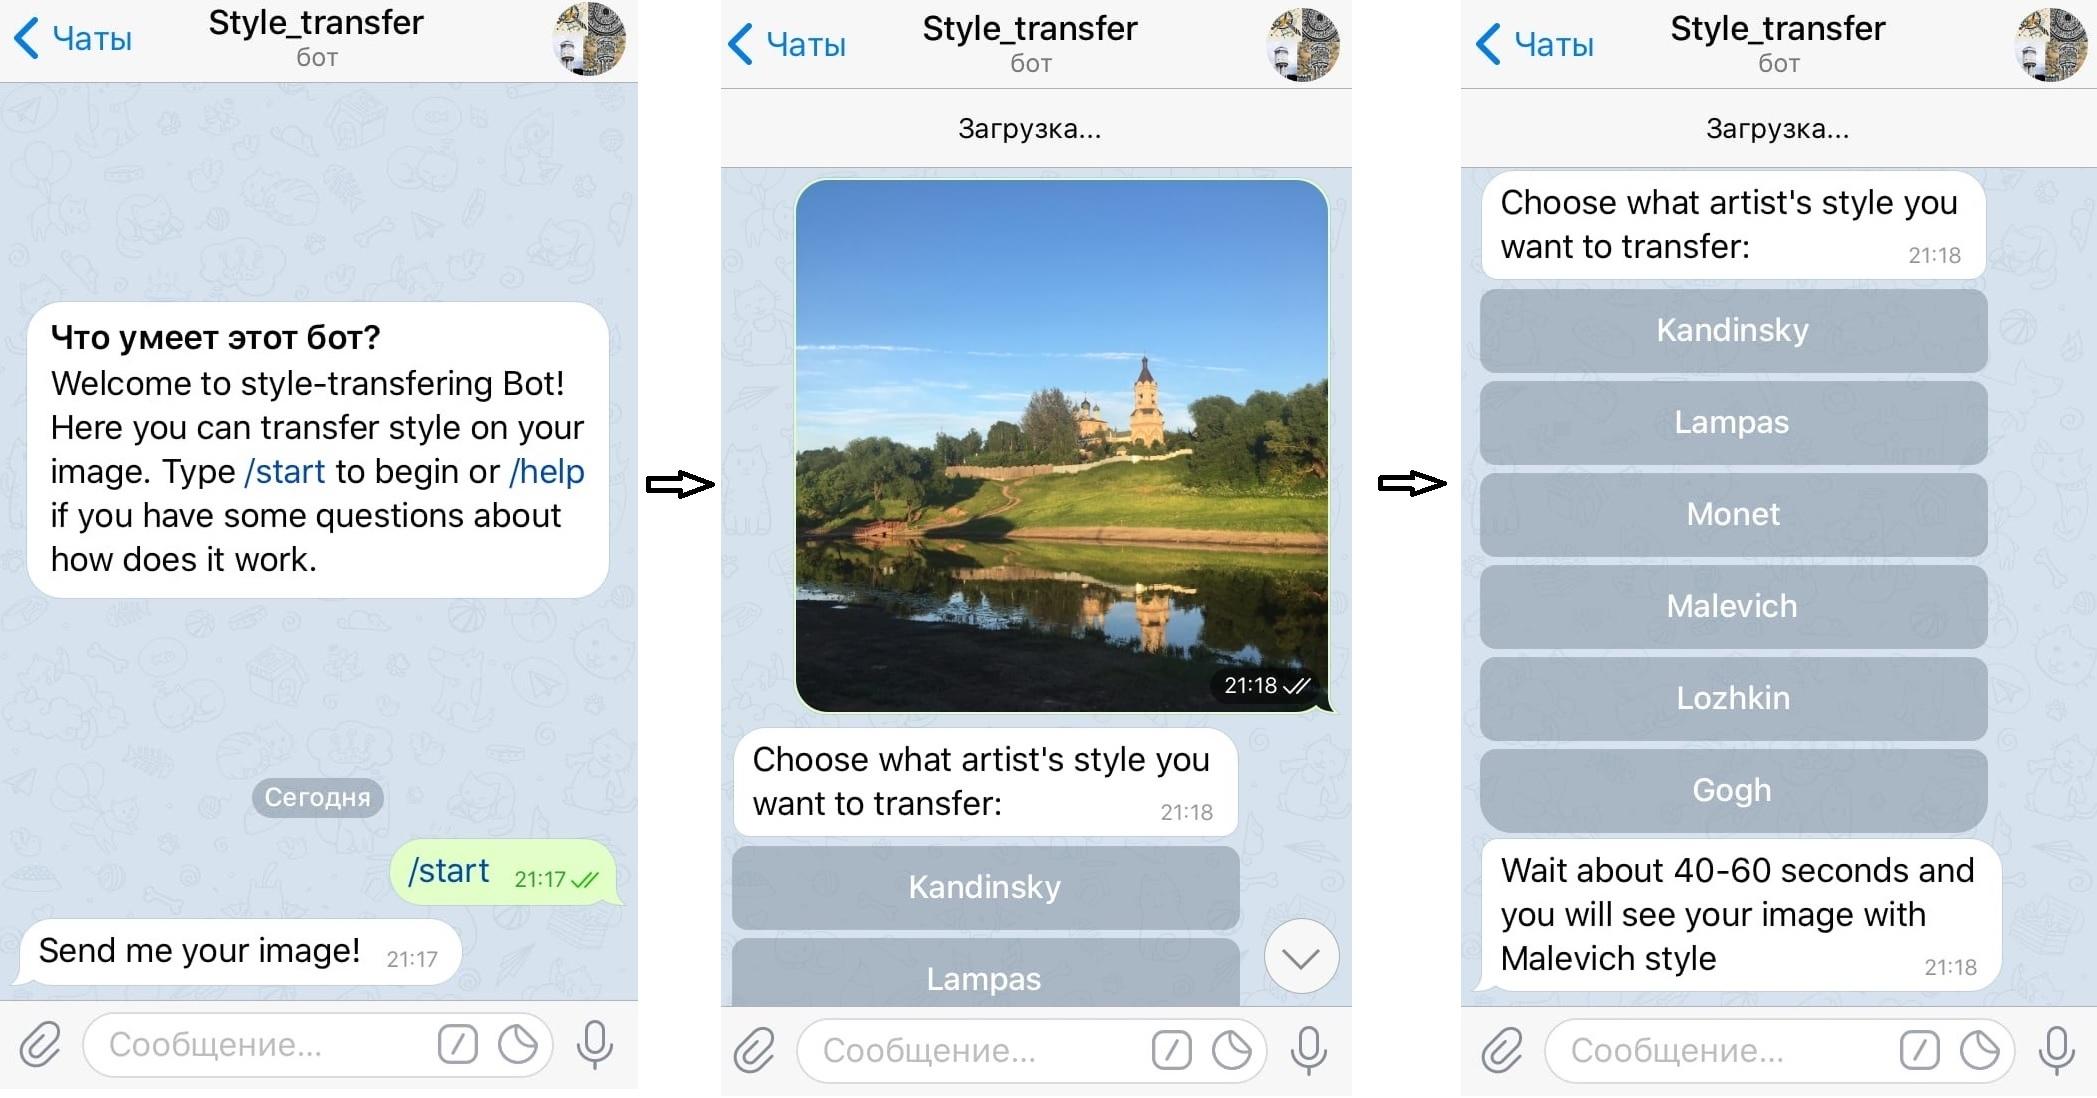

In [16]:
from IPython.display import Image
Image(filename='C:\\Users\\Дарья\\Desktop\\11.jpg',width=800, height=400)

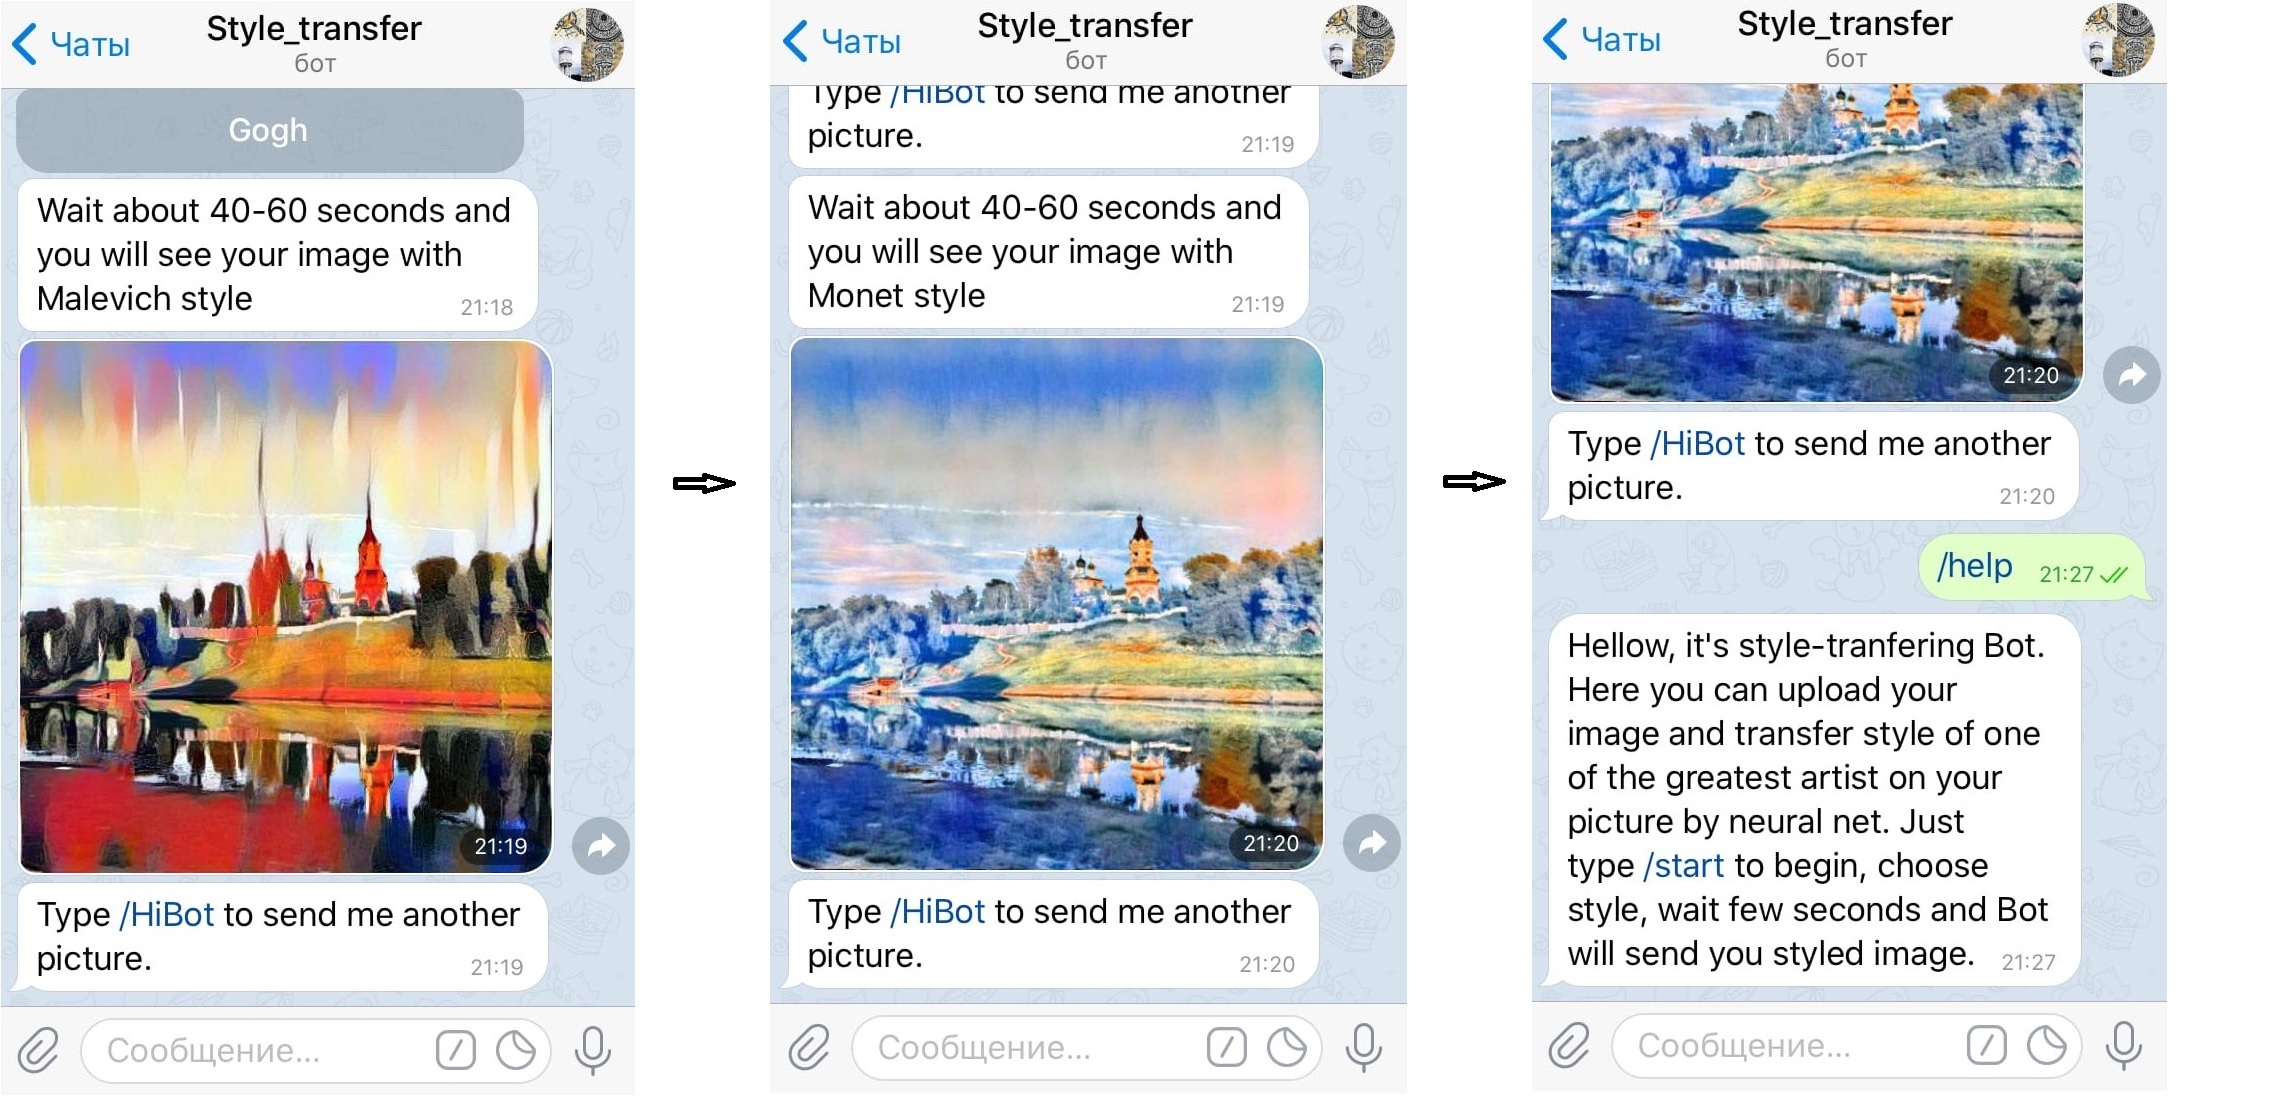

In [14]:
from IPython.display import Image
Image(filename='C:\\Users\\Дарья\\Desktop\\12.jpg',width=800, height=400)